In [34]:
import pandas as pd
import sys
import os
import json
import re
from tqdm import tqdm
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
from rapidfuzz import process, fuzz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, pairwise
import io
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from openai import OpenAI
from typing import Literal, TypedDict, Literal, Dict, Any, List, Union
import os
from typing import Any, Dict
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Literal, TypedDict, Literal, Dict, Any, List, Union
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import BaseTool, StructuredTool, tool
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.graph import MessagesState
import operator
import pandas as pd
from typing import List, Dict, Any, TypedDict
from typing_extensions import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Literal, TypedDict, Literal, Dict, Any, List
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import BaseTool, StructuredTool, tool
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from operator import add
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from collections import Counter



with io.open('/Users/emanueleferrari/desktop/Key.txt', 'r', encoding='utf-8') as file:
        api_key = file.read().strip()

os.environ['OPENAI_API_KEY'] = api_key
del api_key


with open('references/itemStandard.json', 'r') as f:
        REF_ITEMS_STD = json.load(f)

## First Check

In [35]:
def check_initial_results(detected_items: List[str], issues: str):

    class FirstChecAnswer(BaseModel):
        thought: List[str] = Field(..., description="Your thoughts, one on the provided issues, one per identified item, and a conclusive with the overall status")
        note: str = Field(..., description="Your biref note to the next assistant. If no issues are found, you can write 'approved'")
        approved: bool = Field(..., description="If the identified items are correct and no issues are found, set to true. Otherwise, set to false")
        
    first_check_parser = PydanticOutputParser(pydantic_object=FirstChecAnswer)


    first_check_system_prompt = """You are an assistant specialized in approving or report issues on identified items headings in 10-K forms. 

The item should resamble the following:

- item 1&2: business and properties,
- item 1. business,
- item 1a. risk factors,
- item 1b. unresolved staff comments,
- item 1c. cybersecurity,
- item 2. properties,
- item 3. legal proceedings,
- item 4. mine safety disclosures,
- item 5. market for registrant’s common equity, related stockholder matters and issuer purchases of equity securities,
- item 6. selected financial data,
- item 7. management’s discussion and analysis of financial condition and results of operations,
- item 7a. quantitative and qualitative disclosure about market risk,
- item 8. financial statements and supplementary data,
- item 9. changes in and disagreements with accountants on accounting and financial disclosure,
- item 9a. controls and procedures,
- item 9b. other information,
- item 9c. disclosure regarding foreign jurisdictions that prevent inspections,
- item 10. directors, executive officers and corporate governance,
- item 11. executive compensation,
- item 12. security ownership of certain beneficial owners and management and related stockholder matters,
- item 13. certain relationships and related transactions, and director independence,
- item 14. principal accountant fees and services,
- item 15. exhibits, financial statement schedules,
- item 16. form 10-k summary

the relative labels are item01, item01a, item01b, item01c, item02, item03, item04, item05, item06, item07, item07a, item08, item09, item09a, item09b, item09c, item10, item11, item12, item13, item14, item15, item16

**Some important consideration:**
Sometimes item01 and item02 appear combined as item01and02. If item01and02 is present, it replace all items from item01 to item02.
There must be only one item per entry, and the order should be sequential (e.g., item01, item01a item02, item03...) always controll the page number.
Items item01c, item09b, item09c, and item16 are optional and can be absent. If one item is really missing it will be reported to you.
A company may be exempt from reporting certain items or have none, typically item03, item04, or item06. In such cases, the item heading can be replaced with labels like "Item X. None," "Item X. Reserved," "Item X. Not Applicable," "Item X. Omitted," or similar. (where X is the item number)
Items may have minor variations, such as different uses of singular and plural forms, little typos, or inclusion of the company's name, but they should be easily recognizable at the correct target. Those case can be considered correct.
False positives often appear within narrative text (e.g., “see item 1…”, “refer to item 2…”, “item 6 incorporated by reference…”) rather than as standalone headings.
False positives could also appear in tables of contents or within tables that mention items.
Multiple items may be on the same page because their content is short, do not consider it an issue.

**You will be provided***
- a list of identified item headings markdown text and their page numbers
- detected issues (if any) if items are missing, duplicated, or out of order

**Your task**
- aknowledge the issues provided (if any),
- think about every the identified items heading individually, looking for any issues (if any) including if the text look like a false positive, or if the item heading look interrupted or incomplete (or if everything it's correct),
- and report issues (if any) in a brief one two sentences note on the identified items and any additional issues you may have found (if any), that will be provided to the next assistant for further analysis,
- approve or disapprove

**Answer with the following format:**
{{
    thought: List[str] # Your thoughts, one on the provided issues, one per identified item, and a conclusive with the overall status
    note: str = # Your biref note to the next assistant. If no issues are found, you can write 'approved'
    approved: bool # If the identified items are correct and no issues are found (not from you not from the provided issues), set to true. Otherwise, set to false
}}
    """


    first_check_prompt = f"""**Identified items and page numbers:**
    {md_detected_items}

    {issues}
    """


    first_check_system_llm = ChatOpenAI(model='gpt-4o', temperature=0)
    # first_check_system_llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)


    first_check_messages = [(SystemMessage(content=first_check_system_prompt + "\n" + first_check_parser.get_format_instructions()))]
    first_check_messages.append(HumanMessage(content=first_check_prompt))     
    first_check_system_llm = first_check_system_llm.with_structured_output(FirstChecAnswer)
    response = first_check_system_llm.invoke(first_check_messages)

    return response.thought, response.note, response.approved



## Agent Classes

In [36]:
class ItemToKeep(TypedDict):
    id: int
    label: str
    reason: str 

class KeepAnswer(TypedDict):
    note : str
    answer: List[ItemToKeep]

class ItemDictValue(TypedDict):
    label: str
    clean_text: str
    page_number: int

class FalsePositivesSchema(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    df: pd.DataFrame
    items_dict: Dict[int, ItemDictValue]
    duplicate_target_labels: List[str]
    missing_items: List[str]
    items_to_fix: List[int]
    action_log: List[str]
    final_answer: KeepAnswer
    is_last_step: bool
    note_to_next_agent: str
    initial_note: str

class GraphState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    df: pd.DataFrame
    items_dict: Dict[int, ItemDictValue]
    duplicate_target_labels: List[str]
    missing_items: List[str]
    items_to_fix: List[int]
    action_log: List[str]
    note_to_next_agent: str
    initial_note: str

## Supervisor

In [37]:
def reflect_on_data(state, user_message, print_reasoning=False):
  client = OpenAI()

  class Step(BaseModel):
    thought: str
    conclusion: str

  class Answer(BaseModel):
      duplicate_target_labels: List[str]
      missing_items: List[str]
      items_to_fix: List[int]
      next_step: str
      note_to_next_agent: str

  class SupervaisorReasoning(BaseModel):
    steps: list[Step]
    final_answer: Answer

  items_dict = state['items_dict']
  missing_items = state['missing_items']
  items_to_fix = state['items_to_fix']
  

  resoning_examples = []
  system_message = f"""You are a supervisor tasked with overseeing item heading detection in a 10-K filing. Your responsibilities include:
Reasoning through the current state of item headings.
Providing notes about the status and specific candidates, and request to your agents.
Coordinating with and directing different specialized agents.
Updating lists needed for the other agents.

Agents at Your Disposal:

Duplicates Agent:
  This agent specializes in identifying the only correct target and removing false positives between multiple choiches. 
  All items with multpiple candidates must be cleaned from this agent.
  It need multiple choiches for each target label. Ensure to give it only labels that have duplicate entries.
  It require one target label at time

Item Headings Detector:
  This agent searches for missing items by deeply analyzing the document.
  If an item is missing, it will try to find the entry or the best candidates.
  If no item is detected in the entire document, it will explicitly report that no such item is present, and you shuld not ask multiple times to look for specific items.

Item Headings Fixer:
  This agent specializes in identifying if an fix item headings broken or merged with other text blocks. 
  Use it when in item heading seems missing some text parts or is merged with other text blocks.
  It will fix and update, it will report all entries fix results (successfull or not).
  Do not ask to fix the same target multiple times.

Validator:
  This agent will validate the final response. It will approve it, or send it back with some notes.

All agents perform their tasks and update notes on their reasoning and actions taken. Trust their judgment.

Your Input:
You will receive the detected candidates, their id, labels, page numbers, and text blocks.
An inital note with the detected issues.capitalize

Then you will receive messages from the agents with their notes and actions take (a log of sequential notes from previous steps) and the updated item list.

References for each label and the supposed headings are:
    item01: item 1. business,
    item01and02: item 1&2. business and properties,
    item01a: item 1a. risk factors,
    item01b: item 1b. unresolved staff comments,
    item01c: item 1c. cybersecurity,
    item02: item 2. properties,
    item03: item 3. legal proceedings,
    item04: item 4. mine safety disclosures,
    item05: item 5. market for registrant’s common equity, related stockholder matters and issuer purchases of equity securities,
    item06: item 6. selected financial data,
    item07: item 7. management’s discussion and analysis of financial condition and results of operations,
    item07a: item 7a. quantitative and qualitative disclosures about market risk,
    item08: item 8. financial statements and supplementary data,
    item09: item 9. changes in and disagreements with accountants on accounting and financial disclosure,
    item09a: item 9a. controls and procedures,
    item09b: item 9b. other information,
    item09c: item 9c. disclosure regarding foreign jurisdictions that prevent inspections,
    item10: item 10. directors, executive officers and corporate governance,
    item11: item 11. executive compensation,
    item12: item 12. security ownership of certain beneficial owners and management and related stockholder matters,
    item13: item 13. certain relationships and related transactions, and director independence,
    item14: item 14. principal accountant fees and services,
    item15: item 15. exhibits, financial statement schedules,
    item16: item 16. form 10-k summary

Some important consideration:
Sometimes item01 and item02 appear combined as item01and02. If item01and02 is present, it replace all items from item01 to item02.
There must be only one item per entry, and the order should be sequential (e.g., item01, item01a item02, item03...) always controll the page number.
Items item01c, item09b, item09c, and item16 are optional and can be absent. If one item is really missing it will be reported to you in the first message, else assume they are not present.
A company may be exempt from reporting certain items or have none, typically item03, item04, or item06. In such cases, the item heading can be replaced with labels like "Item X. None," "Item X. Reserved," "Item X. Not Applicable," "Item X. Omitted," or similar. (where X is the item number)
IF the detector agent write in the notes that a specific item is not present in the document or was omitted, you must stop looking for it.
Items may have minor variations, such as different uses of singular and plural forms or inclusion of the company's name, but they should be easily recognizable at the correct target.

Your Tasks:
Carefully review all previous notes and detected items. 
Reflect on any instructions or prior considerations about specific items that have already been processed.
Analyze the information thoroughly and write a conclusion note summarizing the overall status of the entries and the process for yourself and the agents.
Identify all duplicate candidates and immediately report them to the Duplicates Agent.
If a candidate appears suspicious or may be a false positive, first search for better candidates, only if you find an alternative you send them to check to the Duplicates Agent.
If no better candidates are found and the item is in the correct order, assume it is correct and do not send it to Duplicates Agent.
Request the Fixer to repair any broken or merged targets.
Search for missing items and assume they are missing if the Detector does not locate them.

If a note instructs you to ignore a specific target or don't call and agent, follow that instruction.

Final Decision Steps:
You will think carefully, step-by-step, considering all notes, information, and detected items heading targets. 
After reasoning, you will provide a next_step choice between:
‘duplicates’ if there are duplicates that may include false positive candidates to resolve. (provide the label one per request)
‘missing’ if there are missing items to find or possible false positives/misplaced items that need an alternative. (provide the labels) 
‘fix’ if some candidates need to be fixed because the item heading appear broken or merged with another text blocks. 
‘validate’  if you are confident that no further action is needed. Before validation you doublecheck that there are no duplicates or missing values, unless already processed by the dedicated agent (look at the notes)

You will also provide:
A brief note tailored for the agent you decide to call. With specific request, any consideration on previous steps that it my be usefull, and the status of the detected items headings.

A list with labels with duplicates entries called duplicate_target_labels (use the labels e.g. 'item01' or 'item07a)
A list of missing candidates and item to search for a better alternative(use labels)
A list of the ids of candidates that need to be fixed (use ids)
"""
# **Reasoning Examples:** {resoning_examples}"""

  completion = client.beta.chat.completions.parse(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message},
    ],
    temperature=0.1,
    response_format=SupervaisorReasoning,
  )

  reasoning = completion.choices[0].message.parsed
  final_answer = reasoning.final_answer

  if print_reasoning:
    for step in reasoning.steps:
      print(step.thought)
      print(step.conclusion)
      print('-'*3)

  # check if final_answer.missing_items contains only items in REF_ITEMS_STD.keys()
  final_answer.missing_items = [
    max(REF_ITEMS_STD.keys(), key=lambda x: fuzz.ratio(x, item[:(min(10, len(item)))]))
    if item not in REF_ITEMS_STD.keys() else item
    for item in final_answer.missing_items
  ]

  # same for duplicate items
  final_answer.duplicate_target_labels = [
    max(REF_ITEMS_STD.keys(), key=lambda x: fuzz.ratio(x, item[:(min(10, len(item)))]))
    if item not in REF_ITEMS_STD.keys() else item
    for item in final_answer.duplicate_target_labels
  ]
  
  final_answer.items_to_fix = [
    item_id for item_id in final_answer.items_to_fix
    if items_dict[item_id]['item'] not in final_answer.duplicate_target_labels
  ]
  
  if print_reasoning: print('Clean final answer: \n', final_answer)

  # upodate reasoning.final_answer with the cleaned final_answer
  reasoning.final_answer = final_answer

  return final_answer, reasoning



## Correct Duplicates

In [38]:
def false_positives_solver(state: FalsePositivesSchema, print_steps=False):
    #######################################################
    # DEFINE LLMS
    #######################################################

    false_positives_solver_llm = ChatOpenAI(model='gpt-4o', temperature=0.2)
    false_positives_validator = ChatOpenAI(model='gpt-4o-mini', temperature=0)
    false_positives_validator = false_positives_validator.with_structured_output(KeepAnswer)



    #######################################################
    # DEFINE TOOLS
    #######################################################

    @tool
    def think_loud(concern:str, thought: str) -> str:
        """Think loud on a specific concern and possible solution.
        
        args:
            concern (str): the concern you have about a specific item or strategy.
            thought (str): the thought regarning the next step.

        return:
            self_note (str): a note to yoiurself with concertn and thought about it
        """
        self_note = f'[CONCERN]: {concern} \n[THOUGHT]: {thought}'
        return self_note

    @tool
    def look_at_the_context(id: int, window:int = 4) -> str:
        """Control the original parsed markdown text of one single target item and the thext block around it in the same page.
        It will return the four lines before and after the target item on the same page (if any), ad the target item itself.
        Args:
            id (int): the id of the item to look at
            window (int): the number of lines before and after the target item to return. Default is 4.
        """
        id = id
        pn = df.loc[id]['page_number']

        window_ids = window*10

        text_before = df[df['page_number']==pn].loc[id-window_ids:id-1]['md_text'].values
        text_before = '\n'.join(text_before)
        # Find the fifth new line in the text
        lines = text_before.split('\n')
        if len(lines) > window:
            text_before = '\n'.join(lines[-window_ids:])
        else:
            text_before = text_before

        text = f'[INSPECTED ID: {id}] '+df.loc[id]['md_text']

        text_after = df[df['page_number']==pn].loc[id+1:id+50]['md_text'].values
        text_after = '\n'.join(text_after)
        # Find the fifth new line in the text
        lines = text_after.split('\n')
        if len(lines) > window:
            text_after = '\n'.join(lines[:window])
        else:
            text_after = text_after
        # join the three text blocks with new line as separator
        text = '\n\n'.join([text_before, text, text_after])
        return text.strip()

    @tool
    def look_an_entire_page(page_number:int) -> str:
        """Control the original parsed markdown text of a spefic page. Use it only if strictly necessary.
        May be useful to check if the item is part of a table of contents or other table.

        It will return the entire text of the page.
        Args:
            page_number (int): the page number to look at
        """
        text = df[df['page_number']==page_number]['md_text'].values
        text = '\n'.join(text)
        return text.strip()


    def tools_to_validation(
        state: Union[list[AnyMessage], dict[str, Any], BaseModel],
        messages_key: str = "messages",
    ) -> Literal["tools", "validation"]:
        """Use in the conditional_edge to route to the ToolNode if the last message
        has tool calls. Otherwise, route to the validation.

        Args:
            state (Union[list[AnyMessage], dict[str, Any], BaseModel]): The state to check for
                tool calls. Must have a list of messages (MessageGraph) or have the
                "messages" key (StateGraph).

        Returns:
            The next node to route to.
        """
        if isinstance(state, list):
            ai_message = state[-1]
        elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
            ai_message = messages[-1]
        elif messages := getattr(state, messages_key, []):
            ai_message = messages[-1]
        else:
            raise ValueError(f"No messages found in input state to tool_edge: {state}")
        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return "tools"
        return "validation"

    false_positives_soover_tools = [look_at_the_context, look_an_entire_page, think_loud]
    false_positives_solver_llm = false_positives_solver_llm.bind_tools(false_positives_soover_tools)




    ########################################################################
    # GET NEW STATE
    ########################################################################
    note_for_agent = state['note_to_next_agent']

    state = FalsePositivesSchema(**state.copy())


    sys_message = SystemMessage(content="""
You are an assistant specialized in identifying the only correct heading and removing false positives of 10-K filing item headings. 

Your task is to select the best option and of specific targets from a given pools of candidates.
For each label you find the best candidate to keep.
It is crucial the only one candidate per targer remain.
If you are ask to evauate a target labels without multiple entries you the supervisor to provide a better alternative first.
                                
**References for each label and the supposed headings are:** 
    item01: item 1. business,
    item01and02: item 1&2. business and properties,
    item01a: item 1a. risk factors,
    item01b: item 1b. unresolved staff comments,
    item01c: item 1c. cybersecurity,
    item02: item 2. properties,
    item03: item 3. legal proceedings,
    item04: item 4. mine safety disclosures,
    item05: item 5. market for registrant’s common equity, related stockholder matters and issuer purchases of equity securities,
    item06: item 6. selected financial data,
    item07: item 7. management’s discussion and analysis of financial condition and results of operations,
    item07a: item 7a. quantitative and qualitative disclosures about market risk,
    item08: item 8. financial statements and supplementary data,
    item09: item 9. changes in and disagreements with accountants on accounting and financial disclosure,
    item09a: item 9a. controls and procedures,
    item09b: item 9b. other information,
    item09c: item 9c. disclosure regarding foreign jurisdictions that prevent inspections,
    item10: item 10. directors, executive officers and corporate governance,
    item11: item 11. executive compensation,
    item12: item 12. security ownership of certain beneficial owners and management and related stockholder matters,
    item13: item 13. certain relationships and related transactions, and director independence,
    item14: item 14. principal accountant fees and services,
    item15: item 15. exhibits, financial statement schedules,
    item16: item 16. form 10-k summary

**Some important consideration:**
Sometimes item01 and item02 appear combined as item01and02. If item01and02 is present, it replace all items from item01 to item02.
There must be only one item per entry, and the order should be sequential (e.g., item01, item01a item02, item03...) always controll the page number.
Items item01c, item09b, item09c, and item16 are optional and will be missing most of the time, the others should be present.
A company may be exempt from reporting certain items or have none, typically item03, item04, or item06. In such cases, the item heading can be replaced with labels like "Item 3. None," "Item 6. Reserved," "Item 4. Not Applicable," "Item 3. Omitted," or similar.
Items may have minor variations, such as different uses of singular and plural forms or inclusion of the company's name, but they should be easily recognizable at the correct target.

**You will receive:**
A note from your supervisor.
A pool of candadiates, with one or more labels. For each candidates their id, page number and cleaned text.
The page number and order within the page of all the detected items headings in the document. There can be some mistakes but use it to evaluate if a target item heading is misplaced.
Notes from previous steps done by you or other agents.
                                                               
**Your Task:**
Determine which items is the most likely target for each provided label. Ensure only one correct item is retained for each target label.
Briefly explain the reason for keeping each individual candidate for every target.
Write a concise note for supervisors and other assistants (including yourself) detailing how the decision on which item to keep was made.                                
                                
**Common false positives to exclude:**
References like “refer to item 1…”, “see item 2…”, or “item 6 incorporated by reference” that are not standalone headings.
Appearances of the target wording in a table of contents or other listing tables.
Very similar titles that  resemble the target item heading, but are simple subheadings of another item section.
Rarely, running heads or repeated references can appear on multiple pages. In these cases, the first entry is often correct unless there is also a table of contents precedes it (in which case the second is often correct).
If you have no better candidates, you can avoid deleting items and ask the suprvisor to look for a better alternative and come back to you.
                                
**Output Format:**
Your final response must be a JSON-like object containing:

The output must be in the following format:
{
    "note": ...
    "answer": List[
        {
            "id": int,
            "label": str,
            "reason": str
        },
        ...
    ]
}
""")                  

    items_dict = state['items_dict']

    duplicate_target_labels = state['duplicate_target_labels']
    items_to_clean = ({k: v for k, v in items_dict.items() if v['item'] in duplicate_target_labels})

    # Count the occurrences of each item
    item_counts = Counter(v['item'] for v in items_to_clean.values())

    # Identify items that have no duplicates (count == 1)
    items_without_duplicates = [item for item, count in item_counts.items() if count == 1]

    # Check if there are any items without duplicates
    if items_without_duplicates:
        # Create a comma-separated string of labels without duplicates
        labels_without_duplicates = ', '.join(items_without_duplicates)
        user_message = (
            f"There are no duplicates for the labels: {labels_without_duplicates}. "
            "Please ask the supervisor to provide a better alternative first."
        )
    
    else:
        items_to_clean = str(items_to_clean)
        full_items_order = str((str({v['item'] : {'page_number':v['page_number'], 'position_in_page':df.loc[k]['pos_in_page']} for k, v in items_dict.items()})))

        
        user_message = 'Possible false positive item labels to check: '+ (str(duplicate_target_labels)) + "\n\n**Pool of candidates (id: {'label': label, 'clean_text': lowercase text without markdown notation, 'page_number': page number}):** \n" + items_to_clean +'\n\nOther detected item heading positions (without text): \n' + full_items_order
        if note_for_agent:
            user_message += '\n\n' + '**Notes:** \n' +  str(note_for_agent)

        if not items_to_clean:
            user_message = f'There was an issue and items to clean are empty. {duplicate_target_labels} shuld be present but no items were found. Please retun note to check data and empty dict.'

        


    #######################################################
    # DEFINE AGENTS
    #######################################################

    def false_positives_agent(state: FalsePositivesSchema): # try FalsePositivesSchema
        # if print_steps: print(state['messages'][:-1]) 

        response =  [false_positives_solver_llm.invoke([sys_message] + state["messages"])]
        # if print_steps: print(response)
        state["messages"].extend(response)
        return state

    def confirm_and_parse_node(state: FalsePositivesSchema) -> Command[Literal["__end__","reasoner"]]:
        last_message = state["messages"][-1]
        # Ensure content is a string
        ids_to_keep = []
        items_dict = state['items_dict'].copy()
        df = state['df'].copy()
        duplicate_target_labels = state['duplicate_target_labels']

        try:
            response = false_positives_validator.invoke([HumanMessage(content=last_message.content)])
            state["messages"].append(AIMessage(content=str(response)))
            state["final_answer"] = response


            for i in response['answer']:
                if i['id'] not in items_dict.keys():
                    raise Exception(f"Item {i} not found in items_dict. Please controll carefully the ID passed.")
                ids_to_keep.append(i['id'])

        except Exception as e:
            state["messages"].append(HumanMessage(content=f"an error occurred: \n{e}"))
            print('\nDEBUG False Positives removal error: ', e, '\n')
            return Command(goto="reasoner")
        

        for id_ in ids_to_keep:
            label = items_dict[id_]['item']
            print(f"Entry with id: {id_} selected from items_dict as best candidate for label '{label}'")

            # 1. Remove from items_dict all entries with the same label (except the chosen id_)
            for k in list(items_dict.keys()):
                if k != id_ and items_dict[k]['item'] == label:
                    del items_dict[k]

            # 2. In df, set 'item' to None for all rows with the same label (except for id_)
            df.loc[(df['item'] == label) & (df.index != id_), 'item'] = None

            # 3. Remove that label from duplicate_target_labels (if it is there)
            if label in duplicate_target_labels:
                duplicate_target_labels.remove(label)

        items_dict = dict(sorted(items_dict.items()))
        update_dict = {'final_answer': response,
                        'items_dict': items_dict, 
                       'duplicate_target_labels': duplicate_target_labels,
                       'df': df}
        

        return Command(update=update_dict, goto="__end__")

        
    #######################################################
    # DEFINE GRAPH
    #######################################################

    false_positives_solver_grap = StateGraph(FalsePositivesSchema)

    # Add nodes
    false_positives_solver_grap.add_node("reasoner", false_positives_agent)
    false_positives_solver_grap.add_node("tools", ToolNode(false_positives_soover_tools)) # for the tools
    false_positives_solver_grap.add_node("validation", confirm_and_parse_node)

    # Add edges
    false_positives_solver_grap.add_edge(START, "reasoner")
    false_positives_solver_grap.add_conditional_edges("reasoner",tools_to_validation)
    false_positives_solver_grap.add_edge("tools", "reasoner")

    false_positives_graph = false_positives_solver_grap.compile()

    messages = [HumanMessage(content=user_message)]

    inputs = {
        # add querry?
        "messages": messages,
        "df": state['df'],
        "items_dict": state['items_dict'],
        "duplicate_target_labels": state['duplicate_target_labels'],
        "missing_items": state['missing_items'],
        "items_to_fix": state['items_to_fix'],
        "action_log": [note_for_agent],
        "is_last_step": False,
        'final_answer': {}
    }
    
    agent_outcome = false_positives_graph.invoke(inputs)

    return agent_outcome



## Detector

In [39]:
def detector_sub_graph(state, target, toc={}):
    # ####################
    # DEFINE TOOLS AND LLMs
    # ####################

    state = state.copy()

 
    supervisor_request = state['note_to_next_agent']
    note_log = state.get("action_log", [])

    notes = [f"[Note {i+1}]: {note}" for i, note in enumerate(note_log)]
    notes = '\n'.join(notes)
    notes = notes.strip()
    
    common_references = REF_ITEMS_STD[target]
    
    df = state['df']
    if type(df) != pd.DataFrame:
        raise ValueError('ERROR! DF is missing.')
    
    known_items = [f'id: {k}, label: {v["item"]}, page_number: {v['page_number']}' for k, v in state['items_dict'].items()]

    known_items = '\n'.join(known_items)
    known_items = known_items.strip()

    class ResearchToolOutcome(TypedDict):
        id: int # The id of the detected text block.
        markdown_text: str # The detected text block.
        text_with_context: str #

    class DetectedItems(TypedDict):
        id: int # the id of the detected item heading.
        strategy_and_parameters: str #A short description of the strategy that identified the target item heading and parameters used to find it.

    class DetectorAnswer(TypedDict):
        note: str  # A short note to the supervisor and other agents with the outcome of the research for the target item.
        detected_items: List[DetectedItems]  # A list of candidates detected items with their context, limited to the individual best candidates (if any) or the best candidates, maximum three elements. Empty if no candidates are detected.



    @tool
    def search_target_item_merged_in_anoter_text_block(search_start_page:int, search_end_page:int, 
                                                                search_without_initial_item_text:bool=True) -> str:
        """Search within the specified page range for a target item heading that may be merged into a text block’s beginning or end.

        - Usefull if you found no entries with 'item' with other tools.
        - The search is restricted to a specified page range. This helps focus on the area where the target item is expected, based on the sequence and position of previously identified items.
        - May give no result candidates, if no candidates are detected.
        - Excludes previously detected items and known false positives.

        Args:
            search_start_page (int): The starting page number (inclusive) for the search range.
            search_end_page (int): The ending page number (inclusive) for the search range.
            search_without_initial_item_text (bool): Defalut True. When True it includes only item headings candidates that do not start with "Item [number]" 
                If False, it includes heading that do not start with "Item [number]".
        """ 
        exclude_previusly_detected_false_positives = True
        threshold = 0.75
        context_window = 30

        # Ensure page bounds are valid
        search_start_page = max(search_start_page, 1)
        search_end_page = min(search_end_page, max(df.page_number))

        df_window = df.copy()
        if exclude_previusly_detected_false_positives:
            df_window = df_window[df_window.noise_type != 'false_positive']

        df_window = df_window[(df_window.page_number >= search_start_page) & (df_window.page_number <= search_end_page)]
        df_window = df_window[df_window['is_noise'] != True]
        df_window = df_window[df_window['item'] != target]

        # rename column md_text to markdown_text
        df_window = df_window.rename(columns={'md_text': 'markdown_text'})
        df_window = df_window.copy()

        if len(df_window) == 0:
            return 'Page range is empty. No candidates found.'
            
        target_variants = REF_ITEMS_STD[target]
        if search_without_initial_item_text: 
            target_variants = [x.split('.')[-1].strip() for x in target_variants]

        def find_top_bounder(text, variant):
            # find the number of words in the variant
            var_words_number = len(variant.split())
            max_words = int(var_words_number * 1.5)+2
            # find the number of words in the text
            text_words_number = len(text.split())
            # if the number of words in the text is less than the number of words in the variant
            if text_words_number <= var_words_number:
                return text.strip()
            else:
                short_text = ' '.join(text.split()[-min(max_words, text_words_number):]).strip()
                return short_text

        def find_bottom_bounder(text, variant):
            # find the number of words in the variant
            var_words_number = len(variant.split())
            max_words = int(var_words_number * 1.5)+2
            # find the number of words in the text
            text_words_number = len(text.split())
            # if the number of words in the text is less than the number of words in the variant
            if text_words_number <= var_words_number:
                return text.strip()
            else:
                short_text = ' '.join(text.split()[-min(max_words, text_words_number):]).strip()
                return short_text

        def ignore_newlines(text):
            return re.sub(r'\s+', ' ', text.replace('\n', ' ')).strip()
        
        results = []


        for variant in target_variants:
            # 1) "Top" pass using partial_ratio
            temp_df_top = df_window.copy()
            temp_df_top['score_top'] = temp_df_top['clean_text'].apply(
                lambda x: fuzz.partial_ratio(x, variant) / 100
            )
            mask_top = (temp_df_top['score_top'] > threshold)
            results.append(temp_df_top.loc[mask_top, ['id','page_number','markdown_text']].to_dict(orient='records'))


        # Flatten the list of lists
        results = [item for sublist in results for item in sublist]

        # Remove duplicates by 'id'
        results = [dict(t) for t in {tuple(d.items()) for d in results}]

        # Sort by 'id'
        results = sorted(results, key=lambda x: x['id'])


        def add_context(results):
            for result in results:
                id = result['id']
                page_number = result['page_number']

                index_page = df_window[df_window['page_number'] == page_number].index
        
                first_ids = [i for i in index_page if id - context_window <= i < id]
                text_before = (df_window[(df_window['page_number'] == page_number) & (df_window['id'] >= id - 50) & (df_window['id'] < id)]['markdown_text'].tolist())
                text_before = [f'[id:{i}] '+t for i,t in zip(first_ids, text_before)]
                text_before = [t +' \n' for t in text_before]
                text_before = ' '.join(text_before)
                text_before = text_before.strip()

                last_ids = [i for i in index_page if id < i <= id + context_window]
                text_after = (df_window[(df_window['page_number'] == page_number) & (df_window['id'] > id) & (df_window['id'] <= id + 50)]['markdown_text'].tolist())
                text_after = [f'[id:{i}] '+t for i,t in zip(last_ids, text_after)]
                text_after = ['\n' + t for t in text_after]
                text_after = ' '.join(text_after)
                text_after = text_after.strip()

                if len(text_before.split()) > context_window:
                    text_before = f' ...' + ' '.join(text_before.split(' ')[-context_window:])
                    # find the first instance of '[id:{digit}]' in the text_before
                    first_id = re.search(r'\[id:(\d+)\]', text_before)
                    # if it exists and it is not the first_ids[0]
                    if first_id and int(first_id.group(1)) != first_ids[0]:
                        # find the element before fitst_id in first_ids
                        index = first_ids.index(int(first_id.group(1)))
                        text_before = f'[id:{first_ids[index-1]}] ' + text_before

                if len(text_after.split()) > context_window:
                    text_after = ' '.join(text_after.split(' ')[:context_window]) + ' ...'
                    # if text after terminates witn '[id:{digit}] ...' remove it
                    text_after = re.sub(r'\[id:(\d+)\] \.\.\.', '', text_after)

                text_with_context = text_before + ' ' + f'[CANDIDATE TEXT id:{result['id']}] "{result['markdown_text']}"' + ' ' + text_after
                result['text_with_context'] = text_with_context

            return results

        results = add_context(results)

        # make result a JSON string
        results = json.dumps(results)

        return results
    

    @tool
    def get_page_text(page_number: int, offset: int = 0) -> str:
        """
        Retrieve the entire page text from the DataFrame by joining all markdown text blocks for that page.

        The resulting output format:
        [id: <index_of_text_block>]: <text_block_content>
        <newline>
        [id: <index_of_text_block>]: <text_block_content>
        ... and so on.

        Args:
            page_number (int): The target page number.
            offset (int): The offset to add to the page number.

        Returns:
            str: The joined markdown text blocks for the specified page, with each block prefixed by its id.
        """
        actual_page = page_number + offset
        df_page = df[df['page_number'] == actual_page]
        
        if df_page.empty:
            return f"No text blocks found for page {actual_page}."

        lines = []
        for _, row in df_page.iterrows():
            lines.append(f"[id: {row['id']}] \n{row['md_text']} \n")
        
        return "\n".join(lines)

    @tool
    def look_id_in_contex(id:int, line_window:int=5) -> str:
        """
        Look for a specific id in the context of the text blocks around it.
        Every text block is prefixed with its id in the output.

        Args:
            id (int): The target id to look for.
            line_window (int): The number of lines to include before and after the target id.
        """
        context_window = line_window * 10

        df_window = df.copy()
        page_number = df_window.loc[id]['page_number']
        # meke the index a new column called id
        ids = df_window.index
        df_window['id'] = ids
        # rename column md_text to markdown_text
        df_window = df_window.rename(columns={'md_text': 'markdown_text'})
        index_page = df_window[df_window['page_number'] == page_number].index
        
        first_ids = [i for i in index_page if id - context_window <= i < id]

        first_ids = (df_window[(df_window['page_number'] == page_number) & (df_window['id'] >= id - context_window)])['id'].tolist()
        text_before = (df_window[(df_window['page_number'] == page_number) & (df_window['id'] >= id - context_window) & (df_window['id'] < id)]['markdown_text'].tolist())
        text_before = [f'[id:{i}] '+t for i,t in zip(first_ids, text_before)]
        text_before = [t +' \n' for t in text_before]
        text_before = ' '.join(text_before)
        text_before = text_before.strip()

        last_ids = [i for i in index_page if id < i <= id + context_window]

        text_after = (df_window[(df_window['page_number'] == page_number) & (df_window['id'] > id) & (df_window['id'] <= id + context_window)]['markdown_text'].tolist())
        text_after = [f'[id:{i}] '+t for i,t in zip(last_ids, text_after)]
        text_after = ['\n' + t for t in text_after]
        text_after = ' '.join(text_after)
        text_after = text_after.strip()

        if len(text_before.split('\n')) > line_window:
            text_before = f' ...' + ' '.join(text_before.split('\n')[-line_window:])
            # find the first instance of '[id:{digit}]' in the text_before
            first_id = re.search(r'\[id:(\d+)\]', text_before)
            # if it exists and it is not the first_ids[0]
            if first_id and int(first_id.group(1)) != first_ids[0]:
                # find the element before fitst_id in first_ids
                index = first_ids.index(int(first_id.group(1)))
                text_before = f'[id:{first_ids[index-1]}] ' + text_before
                # add new line before every [id:
                text_before = re.sub(r'\[id:(\d+)\]', '\n[id:\\1]', text_before)
        if len(text_after.split('\n')) > line_window:
            text_after = ' '.join(text_after.split('\n')[:line_window]) + ' ...'
            # if text after terminates witn '[id:{digit}] ...' remove it
            text_after = re.sub(r'\[id:(\d+)\] \.\.\.', '', text_after)
            # add new line before every [id:
            text_after = re.sub(r'\[id:(\d+)\]', '\n[id:\\1]', text_after)

        

        text_with_context = text_before.strip() + ' ' + f'\n[CANDIDATE TEXT id:{id}] {df_window.loc[id]['markdown_text']} \n' + text_after.strip()

        return text_with_context

    @tool
    def search_for_all_entries_of_item(trigger: str) -> str:
        """
        Search for all entries of a specific item target in the DataFrame, return all lines that contain the item, including all refences anf false positive. 
        Useful as first approach. Can also help idfentify if it is mentioned that the item is missing or in the attachments.
        May give no result candidates, if no candidates are detected.
        Excludes previously detected items and known false positives.

        Parameters:
        - trigger: call the function with a string 'trigger' to start the search.
        """
        exclude_previusly_detected_false_positives = True
        context_window = 30

        # Ensure page bounds are valid
        search_start_page = max(search_start_page, 1)
        search_end_page = min(search_end_page, max(df.page_number))

        search_df = df.copy()

        if exclude_previusly_detected_false_positives:
            search_df = search_df[search_df.noise_type != 'false_positive']

        search_df = search_df[(search_df.page_number >= search_start_page) & (search_df.page_number <= search_end_page)]
        search_df = search_df[search_df['is_noise'] != True]
        search_df = search_df[search_df['item'] != target]


        letter = ''
        if target[-1] == 'a':
            letter = 'a'
        if target[-1] == 'b':
            letter = 'b'
        if target[-1] == 'c':
            letter = 'c'
        number = ''
        if target[4] == '0':
            number = target[5]
        else:
            number = target[4:6]
        
        if len(number)  == 1:
            regex_pattern = rf'item\s?0?{number}\s?{letter}\b'
        else:
            regex_pattern = rf'item\s?{number}\s?{letter}\b'

        if target == 'item01and02':
            regex_pattern = r'items?\s*0?1(?:\s*(?:and|&)\s*0?2|\s+0?2)\b'
        if target == 'item01':
            regex_pattern = r'(' + regex_pattern + r')|(' + r'items?\s*0?1(?:\s*(?:and|&)\s*0?2|\s+0?2)\b)'


        # Compile the regex pattern for performance
        pattern = re.compile(regex_pattern, re.IGNORECASE)

        search_df = search_df[search_df['is_noise'] != True]
        search_df = search_df[search_df['item'].isna()]
        search_df = search_df.rename(columns={'md_text': 'markdown_text'})
        # make index a new column called id
        
        # Option 2 (Recommended): Replace all non-alphanumeric characters with a space
        cleaned_text = search_df['clean_text'].str.replace(r'[^A-Za-z0-9]', ' ', regex=True)
        
        # Collapse multiple whitespaces into one
        cleaned_text = cleaned_text.str.replace(r'\s+', ' ', regex=True).str.strip()
        
        # Assign the cleaned text to a new column for reference (optional)
        search_df = search_df.copy()  # To avoid SettingWithCopyWarning
        search_df['clean_text'] = cleaned_text
        
        # Apply the regex to find matches
        search_df['has_match'] = search_df['clean_text'].apply(lambda x: bool(pattern.search(x)))


        # Filter and return the rows with at least one match
        results = search_df[search_df['has_match']].copy()

        results = results[['id',  'markdown_text', 'page_number']].to_dict(orient='records')
        
        def add_context(results):
            for result in results:
                id = result['id']
                page_number = result['page_number']

                index_page = search_df[search_df['page_number'] == page_number].index
        
                first_ids = [i for i in index_page if id - context_window <= i < id]
                text_before = (search_df[(search_df['page_number'] == page_number) & (search_df['id'] >= id - 50) & (search_df['id'] < id)]['markdown_text'].tolist())
                text_before = [f'[id:{i}] '+t for i,t in zip(first_ids, text_before)]
                text_before = [t +' \n' for t in text_before]
                text_before = ' '.join(text_before)
                text_before = text_before.strip()

                last_ids = [i for i in index_page if id < i <= id + context_window]
                text_after = (search_df[(search_df['page_number'] == page_number) & (search_df['id'] > id) & (search_df['id'] <= id + 50)]['markdown_text'].tolist())
                text_after = [f'[id:{i}] '+t for i,t in zip(last_ids, text_after)]
                text_after = ['\n' + t for t in text_after]
                text_after = ' '.join(text_after)
                text_after = text_after.strip()


                if len(text_before.split()) > context_window:
                    text_before = f' ...' + ' '.join(text_before.split(' ')[-context_window:])
                    # find the first instance of '[id:{digit}]' in the text_before
                    first_id = re.search(r'\[id:(\d+)\]', text_before)
                    # if it exists and it is not the first_ids[0]
                    if first_id and int(first_id.group(1)) != first_ids[0]:
                        # find the element before fitst_id in first_ids
                        index = first_ids.index(int(first_id.group(1)))
                        text_before = f'[id:{first_ids[index-1]}] ' + text_before

                if len(text_after.split()) > context_window:
                    text_after = ' '.join(text_after.split(' ')[:context_window]) + ' ...'
                    # if text after terminates witn '[id:{digit}] ...' remove it
                    text_after = re.sub(r'\[id:(\d+)\] \.\.\.', '', text_after)

                text_with_context = text_before + ' ' + f'[CANDIDATE TEXT id:{result['id']}] "{result['markdown_text']}"' + ' ' + text_after
                result['text_with_context'] = text_with_context

            return results
        
        results = add_context(results)
        
        return results

    @tool
    def think_loud(concern:str, thought: str) -> str:
        """Think loud on a specific concern and possible solution.
        
        args:
            concern (str): the concern you have about a specific item or strategy.
            thought (str): the thought regarning the next step.

        return:
            self_note (str): a note to yoiurself with concertn and thought about it
        """
        self_note = f'[CONCERN]: {concern} \n[THOUGHT]: {thought}'
        return self_note



    def tools_to_validation(
        state: Union[list[AnyMessage], dict[str, Any], BaseModel],
        messages_key: str = "messages",
    ) -> Literal["tools", "validation"]:
        """Use in the conditional_edge to route to the ToolNode if the last message
        has tool calls. Otherwise, route to the validation.

        Args:
            state (Union[list[AnyMessage], dict[str, Any], BaseModel]): The state to check for
                tool calls. Must have a list of messages (MessageGraph) or have the
                "messages" key (StateGraph).

        Returns:
            The next node to route to.
        """
        if isinstance(state, list):
            ai_message = state[-1]
        elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
            ai_message = messages[-1]
        elif messages := getattr(state, messages_key, []):
            ai_message = messages[-1]
        else:
            raise ValueError(f"No messages found in input state to tool_edge: {state}")
        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return "tools"

        return "validation"



    # ####################
    # DETECOTOR AGENT 
    system_prompt_detector = f"""You are an assistant specialized in detecting missing entries of item headings in a 10-K form. The item headings and their corresponding labels are as follows:

Item 1 (label: item01)
Item 1a (label: item01a)
Item 1b (label: item01b)
Item 1c (label: item01c)
Item 2 (label: item02)
Item 3 (label: item03)
Item 4 (label: item04)
Item 5 (label: item05)
Item 6 (label: item06)
Item 7 (label: item07)
Item 7a (label: item07a)
Item 8 (label: item08)
Item 9 (label: item09)
Item 9a (label: item09a)
Item 9b (label: item09b)
Item 9c (label: item09c)
Item 10 (label: item10)
Item 11 (label: item11)
Item 12 (label: item12)
Item 13 (label: item13)
Item 14 (label: item14)
Item 15 (label: item15)
Item 16 (label: item16)
Item 1 & 2 combined (label: item1and2)

The text has been analyzed, and one or more items were found to be missing. 
Occasionally, you will be asked to look for a better candidate for the target.

You will focus on one target heading at a time. Your current target label is: {target}

Common References for the Target:
{common_references}

These references are indicative; the actual text may vary slightly (company name, plurals, minor wording differences) but should remain easily recognizable as the item heading.


Common difficulties:
The item heading may be split across multiple lines.
The item heading may be merged at the top or bottom or within another text block.
The item heading might be replaced with heading “item [index] not applicable” or something similar like "None", "not required"... (often happens for item03, item04, item01b, item06).
An item may be omitted if it’s not required or if there is nothing to report, but usually, the document will mention the omission or include it in attachments.
The item heading might be missing the initial “item [index]” text. (This is rare; be cautious about false positives.)
Items item01c, item09c, item16 are optional and may not appear in the document.
The document may omit an entire part (e.g., Part I (items 1 to 4), Part II (items 5 to 9), Part III (items 10 to 14), Part IV (items 15 and 16)), but this should be mentioned somewhere.
Extraction errors may cause items to be missing or incorrectly extracted.

You Will Receive:
A specific note from the supervisor giving a general view of the document and what you are looking for. Remember, you process one missing item at a time.
Notes from previous agents and their actions.
The target item label.
The clean text and page numbers of all other detected items. These are mostly correct but may include false positives. Use the sequence order to guess where the target should be.

Strategy:
The target item should appear in correct order relative to the one already identified.
First check if there are any entries with the item label in the document. 
If no results, check if the item heading is merged into another text block. Be aware that this may increase the number of false positives.
If the item is merged with another text block, usually is at the beginning or at the end. DO NOT REPORT THESE ITEM IF THE MARKDOWN TEXT IS NOT CLEARLY DISCERNIBLE FROM THE REST OF THE TEXT BLOCK.
If no good candidates are found, report the item as missing. Don't continue searching indefinitely.
Pay attention to previous notes from the supervisor or other agents. They may provide crucial hints or changes in the standard procedure.

Distinguish actual headings from false positives:
If a deceted candidate is in the wrong sequence compared to the majority of other items heading, it is a false positive and you don't report it.
Use the provided common references as a guide to discenr the correct heading from non item headings (false positives).
False positives often appear within narrative text (e.g., “see item 1…”, “refer to item 2…”, “item 6 incorporated by reference…”) rather than as standalone headings.
False positives could also appear in tables of contents or within tables that mention items.
Occasionally, running heads cause multiple false positives. Look at the first few occurrences to identify a pattern.

**You never return narrative text and false positive, only the best heading that could be the target.**

Start with a narrow search and broaden if necessary. If the item is truly missing, report it rather than searching indefinitely.
Start searching at the top and bottom, then in the midle, then a search on entries that contain the item word in the document.

Context and Considerations:
If you find multiple good candidates, report the best match. If uncertain, you may include a small pool of candidates (no more than three), but it’s better to identify a single best match if possible.
If an item heading is split across multiple entries, report the starting entry.
If an item heading is merged into another text block, report the entire entry as found.
If you find a single candidate that is clearly an item heading and have the correcr 'Item X' (X is the number of the item) and is not part of a narrative text, select it.
If all candidates are narrative texts or false positives, report the item as missing.

Required Output Format:
{{
    note: str,  A short note to the supervisor and other agents with the outcome. Only 'item X not present in the document, do not search for it!' if the item is missing, if it was found the srategy that was able to find it.
    detected_items: List[
        {{
            id: int, the id of the detected item
            strategy_and_parameters: str, A short (maximum 25 words) description of the strategy that identified the target item heading and parameters used to find it
        }}
    ]
}}

detected_items can be an empty list if no valid candidate is found. 
**After 10 Tools calls report that you didn't find the target.**"""

    initial_mesage_detector = f"""**Supervisor Request:**
{supervisor_request}

**Notes:** 
{notes}

**Current Target:** {target}

**Already Known Items:**
{known_items}

**If you don't find the item in the first 10 tools call, report that you didn't find the target.**
{f'\n**Detected Table of Contents (remind that is likely offsett, compare with already detected items to find the offset):** \n{toc}' if toc else ''}"""

    
    state['messages'] = [SystemMessage(content=system_prompt_detector),HumanMessage(content=initial_mesage_detector)]
    # LLMs
    detector_tools = [search_target_item_merged_in_anoter_text_block, 
                    #   search_target_item_merged_inside_a_text_block,
            get_page_text, look_id_in_contex, search_for_all_entries_of_item, think_loud]
    
    detector_llm = ChatOpenAI(model='gpt-4o', temperature=0).bind_tools(detector_tools)

    ########################################
    # Validator Ageng

    system_prompt_validator_detector = """You are an assistant specialized in validating the results of the detector agent. 
The detector agent will provide a reason and a list of detected items dictionary, each element with id and strategy and parameter explaination.

Your role is to validate the results and provide a json object with the results of the detector agent and validate of the results.
the object should have the following structure:

{
    note: str  # A short note to the supervisor and other agents with the outcome of the research for the target item.
    detected_items: List[
        {
            id: int # the id of the detected item heading.
            strategy_and_parameters: str #A short description of the strategy that identified the target item heading and parameters used to find it.
        },
        ...
    ] 
}

In case the detector agent specify an item heading broken in multiple subitems you provide the one with lower id.
In case there are multiple candidates but it is not specified that it is broken in multiple subitems you provide all.
In case no item is provided you provide the reason and an empty dic"""

    detector_validator_llm = ChatOpenAI(model='gpt-4o-mini', temperature=0.2).with_structured_output(DetectorAnswer)


    ########################################
    # DEFINE NODES
    ########################################

    def detector_agent(state):
        response =  [detector_llm.invoke(state["messages"])]
        state["messages"].extend(response)
        return state
    
    def validate_and_save(state) -> Command[Literal["__end__","detector"]]:
        last_message = state["messages"][-1]
        
        response =  [detector_validator_llm.invoke([SystemMessage(content=system_prompt_validator_detector), HumanMessage(content=last_message.content)])]

        df = state['df']
        items_dict = state['items_dict']
        detected_items = response[0]['detected_items']
        ids = [(item['id']) for item in detected_items]

        new_note = 'NOTE FROM DETECTOR ASSISTANT: ' + response[0]['note']
        actions_taken = ''
        
        if ids:
            missing_ids = [id for id in ids if id not in df.index]

            if missing_ids:
                print('INVALID ID, TRY AGAIN.')
                raise ValueError(f"Invalid item ids detected: {missing_ids}, please check the ids and try again.")
            
            for id in ids:
                # change the column item of the df to target 
                df.loc[id, 'item'] = target
                # add to items dict list a dict {id:{'label': target, clean_text: df.loc[id, 'clean_text'], page_number: df.loc[id, 'page_number']}}
                new_item = {id:{'item': target, 'clean_text': df.loc[id, 'clean_text'], 'page_number': df.loc[id, 'page_number']}}
                items_dict.update(new_item)
                # reorder the items_dict by id
                items_dict = dict(sorted(items_dict.items()))
                detected_items_dict = {item['id']: item for item in detected_items}
                action = f'id: {id}, labelled as: {target}, reason: {detected_items_dict[id]['strategy_and_parameters']}'
                print(action)
                actions_taken += action
        else:
            print('No Candidate Found.')

        missing_items = state['missing_items']
        missing_items.remove(target)

        if actions_taken:
            actions_taken = f'[ACTIONS TAKEN]: ' + actions_taken
            new_note = new_note + '\n' +actions_taken
        

        update_dict = { 'items_dict': items_dict, 
                        'missing_items': missing_items,
                        'df': df,
                        'action_log': state['action_log'] + [new_note]}
        

        # return Command(update=update_dict, goto="__end__")
        return Command(update=update_dict, goto="__end__")
   
    #######################################
    # DEFINE GRAPH
    #######################################

    detector_grap = StateGraph(FalsePositivesSchema)

    # Add nodes
    detector_grap.add_node("detector", detector_agent)
    detector_grap.add_node("tools", ToolNode(detector_tools)) # for the tools
    detector_grap.add_node("validation", validate_and_save)

    # Add edges
    detector_grap.add_edge(START, "detector")
    detector_grap.add_conditional_edges("detector",tools_to_validation)
    detector_grap.add_edge("tools", "detector")

    compiled_detector_graph = detector_grap.compile()
    
    try: 
        agent_outcome = compiled_detector_graph.invoke(state, {"recursion_limit": 40})
    except RecursionError:
        print('Recursion Error Reached (limit 40). Assume no candidate was found.')
        state['action_log'] = state['action_log'] + ['No Candidate Found.']
        return state
    except Exception as e:
        print(f'An unexpected error occurred: {e}')
        raise  # Re-raise the exception to avoid suppressing it




    return agent_outcome



## Fixer

In [40]:
def fixer_sub_graph(state, target):

    state = state.copy()
    df = state['df']
    items_dict = state['items_dict']
    note_from_supervisor = state['note_to_next_agent']
    items_to_fix = state['items_to_fix']

    
    def add_context_to_text(id,df):
        page_number = df.loc[id]['page_number'] # CAHNGE TO STATE
        rows_window = 70
        line_window = 5

        df_window = df[df['page_number']==page_number].copy()
        # add column id with the index
        index_page = df_window.index
        df_window['id'] = index_page
        # rename clumn md_text to markdown_text
        df_window = df_window.rename(columns={'md_text': 'markdown_text'})

        first_ids = [i for i in index_page if id - rows_window <= i < id]
        text_before = (df_window[(df_window['id'] >= id - rows_window) & (df_window['id'] < id)]['markdown_text'].tolist())
        text_before = [f'[id:{i}] '+t for i,t in zip(first_ids, text_before)]
        text_before = [t +' \n' for t in text_before]
        text_before = ''.join(text_before)
        text_before = text_before.strip()

        last_ids = [i for i in index_page if id < i <= id + rows_window]
        text_after = (df_window[(df_window['id'] > id) & (df_window['id'] <= id + rows_window)]['markdown_text'].tolist())
        text_after = [f'[id:{i}] '+t for i,t in zip(last_ids, text_after)]
        text_after = ['\n' + t for t in text_after]
        text_after = ' '.join(text_after)
        text_after = text_after.strip()

        if len(text_before.split('\n')) > line_window:
            text_before = f'... ' + ' \n'.join(text_before.split('\n')[-line_window:])
            # find the first instance of '[id:{digit}]' in the text_before
            first_id = re.search(r'\[id:(\d+)\]', text_before)
            # if it exists and it is not the first_ids[0]
            if first_id and int(first_id.group(1)) != first_ids[0]:
                # find the element before fitst_id in first_ids
                index = first_ids.index(int(first_id.group(1)))
                text_before = f'[id:{first_ids[index-1]}] ' + text_before.strip()
                # add new line before every [id:
                text_before = re.sub(r'\[id:(\d+)\]', '[id:\\1]', text_before)
            else:
                text_before = f'[id:{first_ids[-1]}] ' + text_before.strip()
                text_before = re.sub(r'\[id:(\d+)\]', '[id:\\1]', text_before)
        if len(text_after.split('\n')) > line_window:
            text_after = '\n'.join(text_after.split('\n')[:line_window]) + ' ...'
            # if text after terminates witn '[id:{digit}] ...' remove it
            text_after = re.sub(r'\[id:(\d+)\] \.\.\.', '', text_after)
            # add new line before every [id:
            text_after = re.sub(r'\[id:(\d+)\]', '[id:\\1]', text_after)

        text_with_context = text_before + ' ' + f'\n[TERGET id:{id}] {df_window.loc[id]['markdown_text']} \n' + '' + text_after
        return text_with_context


    df_bu = df
    history=[df_bu]
    state['history'] = history

    @tool
    def join_target_with_other_rows(ids_to_join:List[int], target_id: int= target) -> str:
        """Join the target row with other rows. 

        Args:
            ids_to_join: List of ids to join with the target_id
        """
        # DF STATE DF
        nonlocal df
        target_md_text = df.loc[target_id]['md_text'].strip()
        target_clean_text = df.loc[target_id]['clean_text'].strip()

        target_md_text = target_md_text + ' ' + ' '.join(df.loc[ids_to_join]['md_text'].to_list())
        target_md_text = target_md_text.replace('** **', ' ')
        target_md_text = target_md_text.replace('** \n**', ' ')  
        target_md_text = target_md_text.replace('**\n **', ' ')
        target_md_text = target_md_text.replace('**\n**', ' ')  

        target_clean_text = target_clean_text + ' '.join(df.loc[ids_to_join]['clean_text'].to_list())


        df.loc[target_id, 'md_text'] = target_md_text
        df.loc[target_id, 'clean_text'] = target_clean_text

        # remove all loc in ids_to_join from df
        df = df.drop(ids_to_join)

        print(f'Target id: {target_id} joined with ids: {ids_to_join}')
        history.append(df)
        
        #STATE DF UPDATE

        return add_context_to_text(target_id,df)

    @tool
    def extract_heading_from_start(heading_end_string: str, target_id: int = target) -> str:
        """
        Extract the heading at the start (top) of the text block (including the boundary match).
        It separates a target item heading at the beginning from the rest of the text block.

        Args: 
            heading_end_string: The string that uniquely marks the end of the heading segment (including markdown formatting)

        Retrurn:
            A string containing the new isolated item heading and the context around it
        """
        nonlocal df
        heading_boundary_regex = re.escape(heading_end_string)
        # Retrieve the full markdown text from the DataFrame
        full_text = df.loc[target_id, 'md_text']

        if target_id not in df.index:
            # Raise vale error ("The target_id is not in the DataFrame. ")
            raise ValueError("The target_id is not in the DataFrame. Check the last message for the updated ids and target id.")

        start_matches = list(re.finditer(heading_boundary_regex, full_text, flags=re.DOTALL))
        if not start_matches:
            # raise value error ("The end boundary was not found in the text. ")
            raise ValueError(f"The end boundary: '{heading_end_string}' was not found in the text. ")
        if len((start_matches)) > 1:
            # Raise Value error ("Multiple end boundaries were found in the text. Plese use a longer and unique boundary string.")
            raise ValueError(f"Multiple end boundaries matches were found in the text for '{heading_end_string}'. Plese use a longer and unique boundary string.")
        
        # Use the last match if there are multiple start matches
        start_match = (start_matches)[0]
        start_text = full_text[:start_match.end()].strip()

        regex = re.compile(r'\*\*\s*\*\*\s*')    
        start_text = re.sub(regex, ' ', start_text)
        start_text = re.sub(r'\s+', ' ', start_text).strip()

        remaining_text = full_text[start_match.end():].strip()
        remaining_text = re.sub(regex, ' ', remaining_text)
        remaining_text = re.sub(r'\s+', ' ', remaining_text).strip()

        # if start_text starts with **, do not end with ** and have an odd number of ** add ** at the end
        if start_text.startswith('**') and not start_text.endswith('**') and start_text.count('**') % 2 != 0:
            start_text = start_text + '**'
            # if remaining text has a odd number of ** add and starts with ** add remove it
            if remaining_text.startswith('**') and remaining_text.count('**') % 2 != 0:
                remaining_text = remaining_text[2:].strip()

        next_row = df.loc[target_id].copy()
        next_row['md_text'] = remaining_text
        # clean text = remaining text lowercase replace markdown ** and _ with whitespace and collpase multiple whitespace in one
        clean_text = remaining_text.lower().replace('**', ' ').replace('_', ' ')
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        next_row['clean_text'] = clean_text
        next_row.name = next_row.name + 1

        df.loc[target_id, 'md_text'] = start_text
        clean_text = start_text.lower().replace('**', ' ').replace('_', ' ')
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        df.loc[target_id, 'clean_text'] = clean_text

        df = pd.concat([df, next_row.to_frame().T])

        # reorder the index
        df = df.sort_index()

        print(f'Target id: {target_id} extracted from start of the text block.')
        history.append(df)

        return add_context_to_text(target_id,df)

    @tool
    def extract_heading_from_end(heading_start_string: str, target_id: int = target) -> str:
        """
        Extract the heading at the end (bottom) of the text block (including the boundary match).
        It separates a target item heading at the end from the rest of the text block.

        Args: 
            heading_start_string: The string that uniquely marks the start of the heading segment (including markdown formatting)

        Retrurn:
            A string containing the new isolated item heading and the context around it
        """
        nonlocal df
        heading_start_regex = re.escape(heading_start_string)

        if target_id not in df.index:
            # Raise vale error ("The target_id is not in the DataFrame. ")
            raise ValueError("The target_id is not in the DataFrame. Check the last message for the updated ids and target id.")

        # Retrieve the full markdown text from the DataFrame
        full_text = df.loc[target_id, 'md_text']

        end_match = list(re.finditer(heading_start_regex, full_text, flags=re.DOTALL))

        if not end_match:
            # raise value error ("The end boundary was not found in the text. ")
            raise ValueError(f"The start boundary: '{heading_start_string}' was not found in the text. ")
        if len((end_match)) > 1:
            # Raise Value error ("Multiple end boundaries were found in the text. Plese use a longer and unique boundary string.")
            raise ValueError(f"Multiple start boundaries were found in the text for' {heading_start_string}'. Plese use a longer and unique boundary string.")
            
        # Use the last match if there are multiple start matches
        end_match = end_match[0]
        header = full_text[end_match.start():]
        intial_text = full_text[:end_match.start()]


        # if start_text starts with **, do not end with ** and have an odd number of ** add ** at the end
        if header.endswith('**') and not header.startswith('**') and header.count('**') % 2 != 0:
            header = '**' + header
            # if remaining text has a odd number of ** add and starts with ** add remove it
            if intial_text.strip().endswith('**') and intial_text.count('**') % 2 != 0:
                intial_text = intial_text.strip()[2:]

        regex = re.compile(r'\*\*\s*\*\*\s*')    
            
        # Perform the substitution globally
        header = re.sub(regex, ' ', header)
        header = re.sub(r'\s+', ' ', header).strip()

        previous_row = df.loc[target_id].copy()
        intial_text = re.sub(regex, ' ', intial_text)
        intial_text = re.sub(r'\s+', ' ', intial_text).strip()
        previous_row['md_text'] = intial_text
        # clean text = remaining text lowercase replace markdown ** and _ with whitespace and collpase multiple whitespace in one
        clean_text = intial_text.lower().replace('**', ' ').replace('_', ' ')
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        previous_row['clean_text'] = clean_text
        previous_row.name = previous_row.name - 1

        df.loc[target_id, 'md_text'] = header
        clean_text = header.lower().replace('**', ' ').replace('_', ' ')
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        df.loc[target_id, 'clean_text'] = clean_text

        df = pd.concat([df, previous_row.to_frame().T])

        # reorder the index
        df = df.sort_index()

        print(f'Target id: {target_id} extracted from end of the text block.')
        history.append(df)

        return add_context_to_text(target_id,df)

    @tool
    def extract_heading_within_block(heading_start_string: str,heading_end_string: str,target_id: int = target) -> str:
        """
        Extract the heading that is merged uniquely within the text block. Not at the beginning, not at the end, and it is not framented.
        It separates a target item heading at the part before and after of the text block.

        Args: 
            heading_start_string: The string that uniquely marks the start of the heading segment (including markdown formatting),
            heading_end_string: The string that uniquely marks the end of the heading segment (including markdown formatting),

        Retrurn:
            A string containing the new isolated item heading and the context around it"""

        nonlocal df        
        if target_id not in df.index:
            # Raise vale error ("The target_id is not in the DataFrame. ")
            raise ValueError("The target_id is not in the DataFrame. Check the last message for the updated ids and target id.")

        start_boundary_regex = re.escape(heading_start_string)
        end_boundary_regex = re.escape(heading_end_string)
        # Retrieve the full markdown text from the DataFrame
        full_text = df.loc[target_id, 'md_text']

        # Search for the start boundary

        start_matches = list(re.finditer(start_boundary_regex, full_text, flags=re.DOTALL))

        if not start_matches:
            # raise value error ("The end boundary was not found in the text. ")
            raise ValueError(f"The start boundary: '{heading_start_string}' was not found in the text. ")
        if len((start_matches)) > 1:
            # Raise Value error ("Multiple end boundaries were found in the text. Plese use a longer and unique boundary string.")
            raise ValueError(f"Multiple start boundaries matches were found in the text for '{heading_start_string}'. Plese use a longer and unique boundary string.")
        
        # Use the last match if there are multiple start matches
        start_match = (start_matches)[0]
        start_text = full_text[start_match.start():]

        end_match = list(re.finditer(end_boundary_regex, start_text, flags=re.DOTALL))

        if not end_match:
            # raise value error ("The end boundary was not found in the text. ")
            raise ValueError(f"The end boundary: '{heading_end_string}' was not found in the text after the start boundary. Please try a different boundary string.")
        if len((end_match)) > 1:
            # Raise Value error ("Multiple end boundaries were found in the text. Plese use a longer and unique boundary string.")
            raise ValueError(f"Multiple end boundaries matches were found in the text for '{heading_end_string}'. Plese use a longer and unique boundary string.")
            
        # Use the last match if there are multiple start matches
        end_match = end_match[0]
        header = start_text[:end_match.end()]
        initial_text = full_text[:start_match.start()] 
        final_text = start_text[end_match.end():]

        
        regex = re.compile(r'\*\*\s*\*\*\s*')    

        previous_row = df.loc[target_id].copy()
        initial_text = re.sub(regex, ' ', initial_text)
        initial_text = re.sub(r'\s+', ' ', initial_text).strip()
        previous_row['md_text'] = initial_text
        # clean text = remaining text lowercase replace markdown ** and _ with whitespace and collpase multiple whitespace in one
        clean_text = initial_text.lower().replace('**', ' ').replace('_', ' ')
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()

        previous_row['clean_text'] = clean_text
        previous_row.name = previous_row.name - 1

        next_row = df.loc[target_id].copy()
        final_text = re.sub(regex, ' ', final_text)
        final_text = re.sub(r'\s+', ' ', final_text).strip()
        next_row['md_text'] = final_text
        # clean text = remaining text lowercase replace markdown ** and _ with whitespace and collpase multiple whitespace in one
        clean_text = final_text.lower().replace('**', ' ').replace('_', ' ')
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        next_row['clean_text'] = clean_text
        next_row.name = next_row.name + 1

        header = re.sub(regex, ' ', header)
        df.loc[target_id, 'md_text'] = header
        clean_text = header.lower().replace('**', ' ').replace('_', ' ')
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        df.loc[target_id, 'clean_text'] = clean_text

        df = pd.concat([df, previous_row.to_frame().T])
        df = pd.concat([df, next_row.to_frame().T])

        # reorder the index
        df = df.sort_index()

        print(f'Target id: {target_id} extracted from within the text block.')
        history.append(df)

        return add_context_to_text(target_id,df)

    @tool
    def extract_fragmented_heading(heading: str, narrative_text:str, target_id: int=target) -> str:
        """Separate the heading that is fragmented in multiple pieces within the target text block.
        Use it only when the heading is fragmented and cannot be separate using another extract tool.

        Args:
            heading (str): The heading that is fragmented (including markdown formatting),
            narrative_text (str): The narrative text of the target text block, {including markdown formatting}.

        Returns:
            str: The new isolated item heading and the context around it.
        """
        nonlocal df
        next_row = df.loc[target_id].copy()
        next_row['md_text'] = narrative_text
        # clean text = remaining text lowercase replace markdown ** and _ with whitespace and collpase multiple whitespace in one
        clean_text = narrative_text.lower().replace('**', ' ').replace('_', ' ')
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        next_row['clean_text'] = clean_text
        next_row.name = next_row.name + 1

        df.loc[target_id, 'md_text'] = heading
        clean_text = heading.lower().replace('**', ' ').replace('_', ' ')
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        df.loc[target_id, 'clean_text'] = clean_text

        df = pd.concat([df, next_row.to_frame().T])
        # reorder the index
        df = df.sort_index()

        print(f'Target id: {target_id} extracted and reconstructed from within the text block.')
        history.append(df)

        return add_context_to_text(target_id,df)

    @tool
    def undo(steps:int, target_id=target) -> str:
        """Undo a number of tool calls to a previous state of the DataFrame by rolling back a number of steps in the history.

        Every step correspoond to a toll call that changed the DataFrame.
        Use it when you want to undo the last changes and start over from a previous step or the initial Dataframe provided with the Human Message.

        Don't use it as first tool call, it will return the same initial state of your initial Human Message.
        Args:
            steps (int): The number of steps to roll back. Every step corresponds to a tool call that changed the DataFrame. Use 0 to rollback to the initial state provided with the Human Message.

        Returns: 
            A string containing the previous isolated item heading and the context around it
        """
        nonlocal df
        nonlocal history
        if steps == 0:
            df = history[0]
            print('Rollback to the initial state.')
        df = history[-steps]
        print(f'Rollback to {steps} steps before.')

        return add_context_to_text(df, target_id)


    def tools_to_validation(
        state: Union[list[AnyMessage], dict[str, Any], BaseModel],
        messages_key: str = "messages",
    ) -> Literal["tools", "validation"]:
        """Use in the conditional_edge to route to the ToolNode if the last message
        has tool calls. Otherwise, route to the validation.

        Args:
            state (Union[list[AnyMessage], dict[str, Any], BaseModel]): The state to check for
                tool calls. Must have a list of messages (MessageGraph) or have the
                "messages" key (StateGraph).

        Returns:
            The next node to route to.
        """
        if isinstance(state, list):
            ai_message = state[-1]
        elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
            ai_message = messages[-1]
        elif messages := getattr(state, messages_key, []):
            ai_message = messages[-1]
        else:
            raise ValueError(f"No messages found in input state to tool_edge: {state}")
        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return "tools"

        return "validation"


    tools_fixer = [join_target_with_other_rows, extract_heading_from_start, extract_heading_from_end, extract_heading_within_block, extract_fragmented_heading, undo]

    item_target = items_dict[target]['item']
    system_message_fixer = f"""You are an assistant specialized in fixing broken and merged detected item headings in the 10-K form.

You will focus only on {item_target}

The common refences for this item headings are:
{REF_ITEMS_STD[item_target]}

These references are indicative; the actual text may vary slightly (company name, plurals, minor wording differences) but should remain easily recognizable as the item heading.

Your task is to fix the target item heading text block using the provided tools and the context of the target item to help you in the process.
Every tool will update you on the target item heading and the context around it.
When you are unable to fix the item heading, you will report it in a note to the supervisor.

The item heading may be split across multiple lines or merged at the top or bottom or within another text block. Rarely the item heading might be fragmented within the text block.

You will receive:
A specific note from the supervisor giving a general view of the document and what you are expected to do.
The target item id and its markdown text block.
The item heading and the context around it. The context comprises the 5 text before and after the target and the relative ids.

Tools:
1. Join the target row with other rows. To use when the target row is split across multiple (usually consecutive) rows.
2. Extract the heading at the start (top) of the text block. When the item heading is merged at the top of the text block in a strucure like '{{item heading}} + {{other narrative text}}'.
3. Extract the heading at the end (bottom) of the text block. When the item heading is merged at the bottom of the text block in a strucure like '{{other narrative text}} + {{item heading}}'.
4. Extract the heading that is merged uniquely within the text block. Not at the beginning, not at the end, and it is not framented, in a structure like '{{other narrative text 1}} + {{item heading}} + {{other narrative text 2}}'.
5. Separate the heading that is fragmented in multiple pieces within the target text block. Use it only when the heading is fragmented and cannot be separate using another extract tool.
6. Rollback to a previous state of the DataFrame. Use it when you want to undo the last changes and start over from a previous state.

Every tool return the processed item heading and the context around it. 

Strategy:
You will first check if the item heading is split across multiple rows and join them, if so you will merge them and wait for the results.
After merging you will check if the new item heading is merged and need to be plitted.

If the item heading is not split across multiple rows, you will perform one single extraction tool to fix the item heading.

Most of the time, you will need to use only one action to fix the item heading. 

If the item heading is still not fixed, you can use another tool to try to fix it.

If you made a mistake can rollback to a previous step;

If you are unable to fix the item heading in few tool calls, you report it to the supervisor.

Your final answer should be:
{{
    was_successful: bool # True if you fixed the item heading, False if you were unable to fix it.
    note: str # A brief note to the suprvisor with the ourcome of your task and the strategy adopted.
}}
    """

    initial_message_fixer = f"""**Supervisor Request:** {note_from_supervisor}
    
**Target Item id** {target}

**Target in Context: **
{add_context_to_text(target, df)}
"""
    
    state['messages'] = [SystemMessage(content=system_message_fixer),HumanMessage(content=initial_message_fixer)]

    fixer_llm = ChatOpenAI(model='gpt-4o', temperature=0).bind_tools(tools_fixer)

    class FixerAnswer(BaseModel):
        was_successful: bool
        note: str

    system_message_fixer_validator = """You are an assistant specialized in validating and parting the results of the fixer agent.
    
    The fixer agent will provide a bool was_successful and note with the outcome of the task and the strategy adopted to fix the item heading.
    If the fixer was able to accomplish the task, was_successful should be true, else, false.
    The note will contain the strategy adopted to fix the item heading.
    
    Your expected output is a json object with the following structure:
    {
        was_successful: bool, # True if the item heading was fixed, False if it was not.
        note: str # A brief note to the supervisor with the outcome of the task and the strategy adopted.
    }"""
    fixer_validator_llm = ChatOpenAI(model='gpt-4o-mini', temperature=0).with_structured_output(FixerAnswer)

    ########################################
    # DEFINE NODES
    ########################################

    def fixer_agent(state):
        response =  [fixer_llm.invoke(state["messages"])]
        state["messages"].extend(response)
        return state
    
    def validate_and_save(state) -> Command[Literal["__end__","fixer"]]:
        last_message = state["messages"][-1]

        response =  [fixer_validator_llm.invoke([SystemMessage(content=system_message_fixer_validator), HumanMessage(content=last_message.content)])]
        items_dict = state['items_dict']

        new_note = 'NOTE FROM FIXER ASSISTANT: ' + response[0].note
        if response[0].was_successful:
            print('Item Fixed. Note: ', new_note)
            new_note = new_note + f'\n ACTION TAKEN: Target id: {target} was fixed.'
            items_dict[target]['clean_text'] = state['df'].loc[target]['clean_text']

            update_dict = {'items_dict': items_dict, 
                            # 'items_to_fix': items_to_fix.remove(target),
                            'df': df,
                            'action_log': state['action_log'] + [new_note]}
        else:
            print('Item Not Fixed. Note: ', new_note)
            update_dict = {'items_dict': items_dict, 
                            # 'items_to_fix': items_to_fix.remove(target),
                            'df': history[0],
                            'action_log': state['action_log'] + [new_note]}
        

        # return Command(update=update_dict, goto="__end__")
        return Command(update=update_dict, goto="__end__")
   
    #######################################
    # DEFINE GRAPH
    #######################################

    fixer_grap = StateGraph(FalsePositivesSchema)

    # Add nodes
    fixer_grap.add_node("fixer", fixer_agent)
    fixer_grap.add_node("tools", ToolNode(tools_fixer)) # for the tools
    fixer_grap.add_node("validation", validate_and_save)

    # Add edges
    fixer_grap.add_edge(START, "fixer")
    fixer_grap.add_conditional_edges("fixer",tools_to_validation)
    fixer_grap.add_edge("tools", "fixer")

    compiled_fixer_graph = fixer_grap.compile()
    
    try: 
        agent_outcome = compiled_fixer_graph.invoke(state, {"recursion_limit": 15})
    except RecursionError:
        print('Recursion Error Reached (limit 15). Assume the agent was not able to fix the item.')
        state['action_log'] = state['action_log'] + ['The agent was not able to fix target with id: {target}. Ignore this target from now on.']
        return state
    except Exception as e:
        print(f'An unexpected error occurred: {e}')
        raise  # Re-raise the exception to avoid suppressing it


    return agent_outcome


# Main Graph

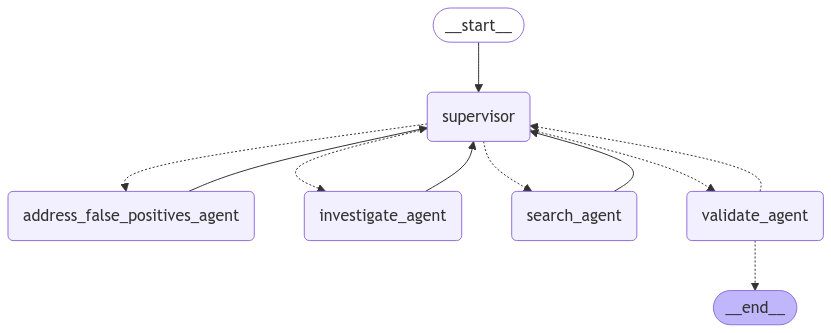

In [41]:
#######################################################
# NODES
#######################################################
def supervisor_node(state: GraphState) -> Command[
    Literal["address_false_positives_agent","investigate_agent","search_agent","validate_agent"]
]:
    # print('~~~'*3)
    # print("CALLED Supervisor")
    # print()
    
    notes = state.get("action_log", [])
    # if notes:
    #     print('LAST NOTE: ', state.get("action_log", [])[-1])
    #     print()
    # Extract current known data
    items_dict = state["items_dict"]

    # print(items_dict)
    # print()

    # for k, v in items_dict.items():
    #     print('id:', k, ', label:', v['item'], ', page number:', v['page_number'], ', \nclean text:', v['clean_text'])
    # print()
    
    note_log = state.get("action_log", [])
    # join notelog separator new line
    log = [f"[Note {i+1}]: {note}" for i, note in enumerate(note_log)]
    log = '\n'.join(log)

    # if note_log:
    #     print("NOTES: ")
    #     print(log)
    #     print()

    initial_note = state["initial_note"]
    
    user_message = ""
    if log: 
        user_message += f"**Notes from previous steps:** \n{log}\n\n"
    elif initial_note:
        user_message += f'{initial_note}\n\n'


    item_founded = ('\n'.join(['id: ' + str(k) + ', label: ' + str(v['item']) + ', page number: ' + str(v['page_number']) + ', \nclean text: ' + str(v['clean_text']) + '\n' for k, v in items_dict.items()]))

    user_message += f"Here is the last update of detected items: {item_founded}"
    # print(user_message)
    # print()

    # Reflect on the data
    answer, reasoning = reflect_on_data(state, user_message, print_reasoning=False)
    # print(answer)
    # print('~~~'*3)    
    
    # Prepare updates to the state
    update_dict = {
        "duplicate_target_labels": answer.duplicate_target_labels,
        "missing_items": answer.missing_items,
        "items_to_fix": answer.items_to_fix,
        "action_log": note_log + ["SUPERVISOR NOTE: " + answer.note_to_next_agent],
        "messages": [
            HumanMessage(content=user_message),
            AIMessage(content=str(reasoning.steps[-1].conclusion))],
        "note_to_next_agent": answer.note_to_next_agent
    }

    # print('CONCLUSOIN: \n', reasoning.steps[-1].conclusion)
    # print()
    # print('NOTE TO NEXT AGENT:')
    # print(answer.note_to_next_agent)
    # print()
    # print('END SUPERVISOR')
    # print('~~~'*3)
    # print()
    


    next_step = answer.next_step.lower().strip()
    if  next_step == 'validate':
        return Command(update=update_dict, goto="validate_agent")
    if next_step == 'fix':
        return Command(update=update_dict, goto="investigate_agent")
    if next_step == 'duplicates':
        return Command(update=update_dict, goto="address_false_positives_agent")
    if next_step == 'missing':
        return Command(update=update_dict, goto="search_agent")
    
    possible_steps = ["validate", "fix", "duplicates", "missing"]
    best_match = max(possible_steps, key=lambda step: fuzz.ratio(step, next_step))

    if fuzz.ratio(best_match, next_step) > 80:
        # print(f"REROUTED FROM {next_step} TO BEST OPTION: {best_match}")
        return Command(update=update_dict, goto=f"{best_match}_agent")
    else:
        # print(f"REROUTED FROM {next_step} TO VALIDATE")
        return Command(update=update_dict, goto="validate_agent")
    

# address_false_positives_node
def address_false_positives_node(state: GraphState):
    # print("CALLED Address False Positives")
    print("identifying Best option for:", state['duplicate_target_labels'])
    
    agent_outcome = false_positives_solver(state, print_steps=False)

    final_answer = agent_outcome.get("final_answer", [])
    final_answer = agent_outcome.get("final_answer", {})
    note = final_answer.get("note", "")
    actions = final_answer.get("answer", [])
    
    actions_str = " ".join([f"id {action['id']} with label {action['label']} was selected. Reason: {action['reason']}\n" for action in actions]).strip()
    log = f"NOTE FROM FALSE POSITIVES ASSISTANT: {note}"
    if actions_str:
        log += f"\n[ACTIONS TAKEN]: {actions_str}"
        
    action_log = state.get("action_log", [])
    action_log += [log]

    # print('UPDATE TO LOG: \n', log)
    
    # state["messages"].extend(AIMessage(content=final_answer['answer']))

    update_dict = {
        "action_log": action_log,
        "items_dict": agent_outcome['items_dict'],
        "duplicate_target_labels": agent_outcome['duplicate_target_labels']
    }
    
    # print()
    return Command(update=update_dict, goto="supervisor")


# investigate_agent_node
def investigate_agent_node(state: GraphState):
    # print("CALLED Fixer agent")

    answer_state = state.copy()
    items_to_fix = state['items_to_fix'].copy()
    if type(items_to_fix) == int:
        items_to_fix = [items_to_fix]
    print('Items to Fix:', items_to_fix)

    for target in items_to_fix:
        print('Fixing items:', target, '...')
        answer_state = fixer_sub_graph(answer_state, target=target)
    
    update_dict = {
        'items_dict' : answer_state['items_dict'],
        'action_log' : answer_state['action_log'],
        'items_to_fix' : [],
        'df' : answer_state['df']
    }  

    # Return the Command with the updated action_log
    return Command(update=update_dict, goto="supervisor")


# search_agent_node
def search_agent_node(state: GraphState):
    # print("CALLED Detecor agent")

    answer_state = state.copy()
    missing_items = state['missing_items'].copy()
    print('Searcing for Missing Items:', missing_items)

    for target in missing_items:
        # print('\tSearching for:', target, '...')
        answer_state = detector_sub_graph(answer_state, target=target)

    update_dict = {
        'items_dict' : answer_state['items_dict'],
        'action_log' : answer_state['action_log'],
        'missing_items' : answer_state['missing_items'],
        'df' : answer_state['df']
    }

    # Return the Command with the updated action_log
    return Command(update=update_dict, goto="supervisor")


# validate_agent_node
def validate_agent_node(state: GraphState) -> Command[Literal["supervisor","__end__"]]:
    
    # TODO: VALIDATE THE FINAL ANSWER

    print()
    print('FULL LOG:')
    notes = state.get("action_log", [])
    if notes:
        notes = '\n'.join(notes)
        print(notes)
        print()
    # For demonstration, let's always end
    return Command(goto=END)


#######################################################
# BUILD GRAPH
#######################################################

# Build the graph
builder = StateGraph(GraphState)

# Start goes to supervisor
builder.add_edge(START, "supervisor")

# Add the supervisor and agent nodes
builder.add_node("supervisor", supervisor_node)
builder.add_node("address_false_positives_agent", address_false_positives_node)
builder.add_node("investigate_agent", investigate_agent_node)
builder.add_node("search_agent", search_agent_node)
builder.add_node("validate_agent", validate_agent_node)

# Add the edges
builder.add_edge("address_false_positives_agent", "supervisor")
builder.add_edge("investigate_agent", "supervisor")
builder.add_edge("search_agent", "supervisor")

graph = builder.compile()

# Display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))



In [42]:
def item_heading_detection_pipeline(df_processed, items_dict, initial_note):
    initial_state = {
        "messages": [],
        "df": df_processed,
        "items_dict": items_dict,
        "missing_items": [],
        "duplicate_target_labels": [],
        "items_to_fix": [],
        "action_log": [],
        "initial_note": initial_note
    }

    # Invoke the graph
    result = graph.invoke(initial_state)

    return result['df'], result['items_dict'], result['action_log'], result['messages'], result['messages'][-2]

# Run Pipeline

In [44]:
import os
import json

folder_path = 'outputs/test'

filenames = [f for f in os.listdir(folder_path) if f.startswith('t')]
filenames = sorted(filenames)

# # Check if df_with_issues.json exists in the folder path
# issues_file_path = os.path.join(folder_path, 'df_with_issues.json')
# if os.path.exists(issues_file_path):
#     with open(issues_file_path, 'r') as file:
#         df_with_issues = json.load(file)
#     filenames = df_with_issues
#     filenames = sorted(filenames)

df_with_issues = []

for filename in filenames[:]:
    print(f"Document ID: {filename}")

    df = pd.read_parquet(f'{folder_path}/{filename}/df_item_fuzz.parquet')

    for part in ['part i.', 'part ii.', 'part iii.', 'part iv.']:
        df = df[df['clean_text'].str.lower() != part.lower()].copy()

    # add a column id with the index values
    df['id'] = df.index

    # Load the JSON file
    with open(f'{folder_path}/{filename}/item_fuzz.json', 'r') as json_file:
        previous_outcome = json.load(json_file)

    missing_items = previous_outcome['missing']
    duplicated_items = previous_outcome['duplicates']
    misplaced_items = previous_outcome['misplaced']
    detected_items = previous_outcome['detected']

    md_detected_items = [{'text': df.loc[i['id']]['md_text'], 'page': str(i['page'])} for i in detected_items]
    md_detected_items = '\n'.join([f"page {i['page']}, \ttext: {i['text']}" for i in md_detected_items])

    print(f"Detected items: \n{md_detected_items}")

    if md_detected_items.strip() == '':
        print('No items detected')
        md_detected_items = 'No items detected'
        

    issues = f"missing items: {missing_items}\n" if missing_items else ''
    issues += f"duplicated items: {duplicated_items}\n" if duplicated_items else ''
    issues += f"misplaced items: {misplaced_items}" if misplaced_items else ''
    issues = issues.strip()

    print()
    if issues:
        print(f'initial detected issues: \n{issues}')
        issues = f'Detected issues: \n{issues.strip()}\n'

    else:
        print('No initial issues detected')
        issues = 'No initial issues detected'


    first_check_thought, note, approved = check_initial_results(md_detected_items, issues)

    if approved:
        if issues == 'No initial issues detected':
            print('Approved')
            df.index.name = 'index'
            df.to_parquet(f'{folder_path}/{filename}/df_stage2early.parquet')
            print('-'*50)
            continue            

    print('Not approved')
    print()

    if note.strip().lower() != 'approved':
        initial_note = f"INITIAL ISSUES DETECTED: '/n{issues} INITIAL NOTE: \n\n{note}"
    elif issues != 'No initial issues detected':
        initial_note = f"INITIAL ISSUES DETECTED: {issues}"
    else:
        initial_note = ''

    print('Initial Note:', initial_note)
    
    df_bu = df.copy()


    items_dict = {e['id']: {'item':e['label'], 'page_number': e['page'], 'clean_text':e['text']} for e in detected_items}
    try:
        print('STARTING PIPELINE')
        df, items_dict, action_log, messages, last_message = item_heading_detection_pipeline(df, items_dict, initial_note=initial_note)
        df.index.name = 'index'

        df.to_parquet(f'{folder_path}/{filename}/df_item_llm.parquet')
        items_detected = [{'item': v['item'], 'page': float(v['page_number']), 'text': v['clean_text']} for k, v in items_dict.items()]
        with open(f'{folder_path}/{filename}/item_llm.json', 'w') as file:
            json.dump(items_detected, file, indent=4)
        with open(f'{folder_path}/{filename}/action_log_item.json', 'w') as file:
            json.dump(action_log, file, indent=4)
        with open(f'{folder_path}/{filename}/messages_item.json', 'w') as file:
            json.dump(str(messages), file, indent=4)
        with open(f'{folder_path}/{filename}/last_message_item.json', 'w') as file:
            json.dump(str(last_message), file, indent=4)
            
    except Exception as e:
        print('ERROR:', e)
        df.index.name = 'index'
        df_bu.to_parquet(f'{folder_path}/{filename}/df_stage2failed.parquet')
        items_detected = [{'item': v['item'], 'page': float(v['page_number']), 'text': v['clean_text']} for k, v in items_dict.items()]
        with open(f'{folder_path}/{filename}/item_llm.json', 'w') as file:
            json.dump(items_detected, file, indent=4)
        # export json error
        with open(f'{folder_path}/{filename}/error_item.json', 'w') as file:
            json.dump(str(e), file, indent=4)

    print()
    print(items_dict)
    print('\n', '_'*50, '\n')

    print('-'*50)
    df_with_issues.append(filename)

# dump df_with_issues list in folder 
with open(f'{folder_path}/df_with_issues.json', 'w') as file:
    json.dump(df_with_issues, file, indent=4)


Document ID: ts00_0000004127_0000004127-13-000056
Detected items: 
page 4, 	text: **ITEM 1. BUSINESS**
page 10, 	text: **ITEM 1A. RISK FACTORS.**
page 22, 	text: **ITEM 1B. UNRESOLVED STAFF COMMENTS.**
page 22, 	text: **ITEM 2. PROPERTIES.**
page 22, 	text: **ITEM 3. LEGAL PROCEEDINGS.**
page 22, 	text: **ITEM 4. MINE SAFETY DISCLOSURES.**
page 23, 	text: **ITEM 5. MARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS ANDISSUER PURCHASES OF EQUITY SECURITIES.**
page 23, 	text: **ITEM 6. SELECTED FINANCIAL DATA.**
page 24, 	text: **ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTSOF OPERATIONS.**
page 32, 	text: **ITEM 7A. QUANTITATIVE AND QUALITATIVE DISCLOSURES ABOUT MARKET RISK.**
page 34, 	text: **ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY DATA.**
page 59, 	text: **ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCOUNTANTS ON ACCOUNTING ANDFINANCIAL DISCLOSURE.**
page 59, 	text: **ITEM 9A. CONTROLS AND PROCEDURES.**
page 60, 	text: **ITEM 9B

In [11]:
print(len(df_with_issues), 'files with issues')
print(df_with_issues)


13 files with issues
['ts05_0000018230_0000018230-19-000034', 'ts11_0000037996_0000037996-14-000010', 'ts16_0000059478_0000059478-22-000068', 'ts18_0000063908_0000063908-22-000011', 'ts25_0000105770_0000105770-15-000007', 'ts26_0000106535_0000106535-13-000011', 'ts30_0000711404_0000711404-14-000017', 'ts33_0000723254_0000723254-23-000025', 'ts34_0000732717_0000732717-18-000009', 'ts39_0000766704_0000766704-21-000018', 'ts40_0000773840_0000930413-13-000907', 'ts42_0000788784_0000788784-20-000004', 'ts45_0000831259_0000831259-19-000009']


In [3]:
import pandas as pd
import json

df = pd.read_parquet('outputs/test/ts42_0000788784_0000788784-20-000004/df_stage2llm.parquet')
df.columns

Index(['doc_id', 'page_number', 'pos_in_page', 'md_text', 'clean_text', 'item',
       'type', 'emb', 'is_noise', 'noise_type', 'detected_page_number'],
      dtype='object')